In [1]:
from diffractionDataAnalysis_class import DiffractionDataAnalysis

In [2]:
DIFF_View_1 = DiffractionDataAnalysis(
    "/dls/staging/dls/k11/data/2024/mg34950-1/processed/k11-38031-diffraction-DiffInt_HarmCakeAzzTxt.nxs",
    "/dls/staging/dls/k11/data/2024/mg34950-1/processed/Savu_k11-38030_full_fd_rr_vo_AST_tiff/k11-38030_processed.nxs",
    "/dls/staging/dls/k11/data/2024/mg34950-1/processing/image", 0, 'Histogram')

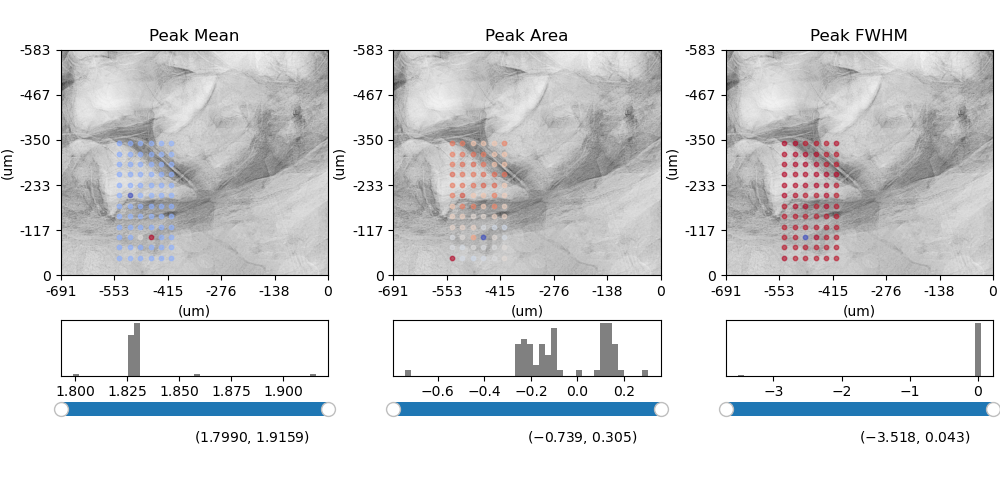

In [3]:
DIFF_View_1.ImageCorrelatedCrystallography(1.73,1.94,1)

In [11]:
print(DIFF_View_1.pk_Mean[3][9], DIFF_View_1.pk_Area[3][9], DIFF_View_1.pk_fwhm[3][9], DIFF_View_1.pk_popt[3][9])

1.915868380414718 -0.7390505602161097 0.03882536906562841 [-7.29555762e+00  1.91586838e+00  2.79417706e-02 -1.19553536e+00
 -8.99495582e+01  5.27352782e+01]


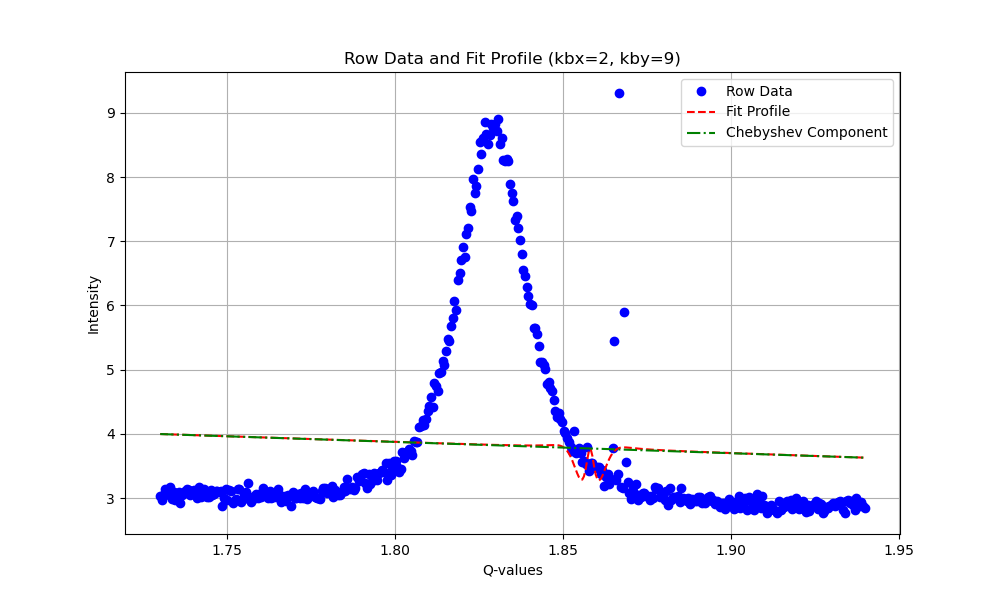

In [13]:
DIFF_View_1.plot_row_with_fit(2,9,1.73,1.94)

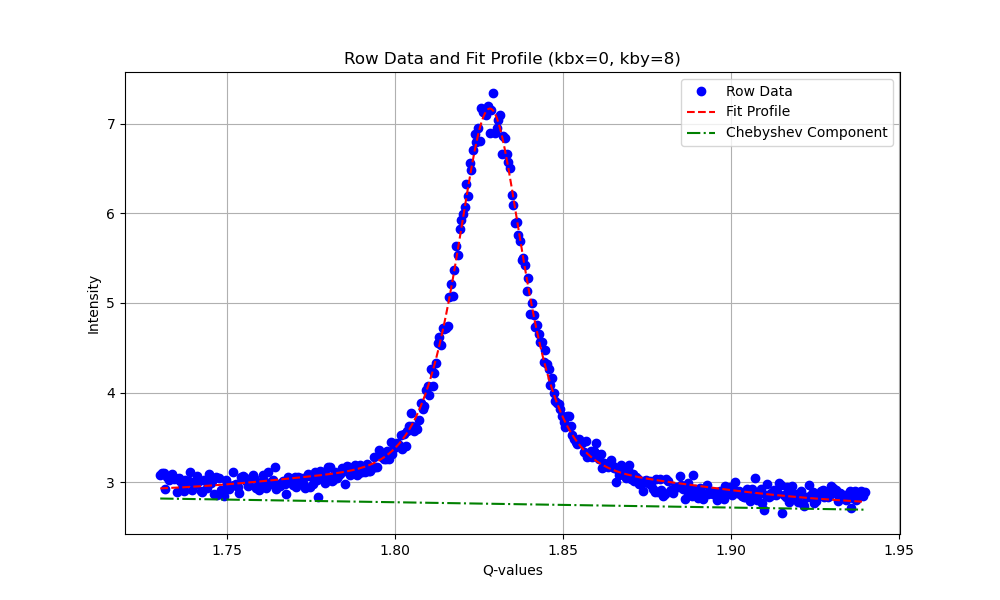

In [5]:
DIFF_View_1.plot_row_with_fit(0,8,1.73,1.94)

If a Chabichef is included the fit reurns negative values which are unphysical!!!!

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.widgets import Button
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.cm as cm
#%matplotlib widget

from ipyfilechooser import FileChooser
import h5py
import os, sys, glob
import pandas as pd
import ipympl
from matplotlib.patches import Rectangle

from scipy.optimize import curve_fit

In [4]:
Dif_Path = "/dls/staging/dls/k11/data/2024/mg34950-1/processed/k11-38031-diffraction-DiffInt_HarmCakeAzzTxt.nxs"

In [5]:
with h5py.File(Dif_Path,'r') as f:
    Ivals=f['processed/result/data'][()]
    dim=len(Ivals.shape)-1
    
    if 'processed/result/q' in f:
        qvs2t="Scattering Momentum"
        qvals=f['processed/result/q'][()]
    elif 'processed/result/2-theta' in f:
        qvs2t="2-Theta Angle"
        qvals=f['processed/result/2-theta'][()]

    if 'processed/result/kb_cs_x' in f:
        kbx = f['processed/result/kb_cs_x'][()]
    elif 'entry/diffraction/kb_cs_x' in f:
        kbx = f['entry/diffraction/kb_cs_x'][()]
    
    if 'processed/result/kb_cs_y' in f:
        kby = f['processed/result/kb_cs_y'][()]
    elif 'entry/diffraction/kb_cs_y' in f:
        kby = f['entry/diffraction/kb_cs_y'][()]
    
    if 'processed/result/gts_theta' in f:
        theta = round(f['processed/result/gts_theta'][()].max(),2)
    elif 'entry/diffraction_sum/gts_theta' in f:
        theta = round(f['entry/diffraction_sum/gts_theta'][()].max(),2)

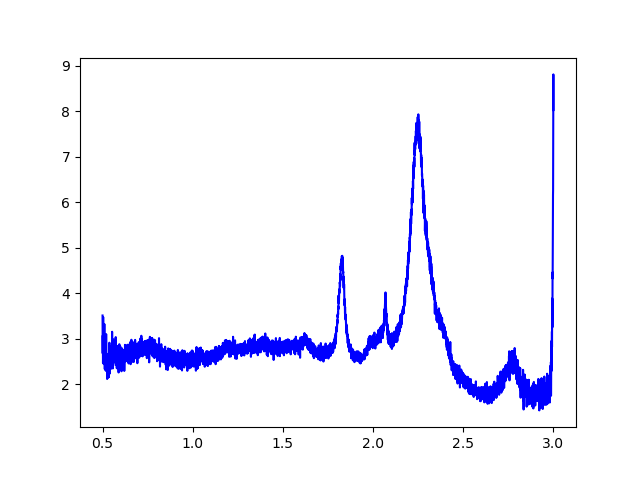

In [11]:
def plot_kb_data(kbx, kby, title="KB Data Plot", xlabel="KB X", ylabel="KB Y"):
    plt.figure(figsize=(5, 4))
    plt.plot(qvals, Ivals[1][1], color='b')
    plt.show()
plot_kb_data(1,1)

In [20]:
def pseudo_voigt(x, amplitude, center, sigma, fraction):
    """ Pseudo-Voigt profile function """
    sigma_g = sigma / np.sqrt(2 * np.log(2))
    sigma_l = sigma / 2
    gauss = (1 - fraction) * np.exp(-((x - center) ** 2) / (2 * sigma_g ** 2))
    lorentz = fraction / (1 + ((x - center) / sigma_l) ** 2)
    return amplitude * (gauss + lorentz)

def chebyshev(x, *coeffs):
    """ Chebyshev polynomial of the first kind """
    return np.polynomial.chebyshev.chebval(x, coeffs)

def combined_function(x, amplitude, center, sigma, fraction, *cheb_coeffs):
    """ Combined Pseudo-Voigt and Chebyshev function """
    return pseudo_voigt(x, amplitude, center, sigma, fraction) + chebyshev(x, *cheb_coeffs)

def plot_refined_curve(x_fit, y_fit, popt):
    plt.figure(figsize=(10, 6))
    plt.plot(x_fit, y_fit, 'bo', label='Source Data')
    plt.plot(x_fit, combined_function(x_fit, *popt), 'r-', label='Refined Curve')
    plt.title('Refined Curve Overlay on Source Data')
    plt.xlabel('X')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

def fit_combined(x_fit, y_fit, n):
    # Initial guess for the parameters
    initial_guess = [max(y_fit), x_fit[np.argmax(y_fit)], np.std(x_fit), 0.5] + [0] * (n + 1)

    # Fit the combined function
    popt, _ = curve_fit(combined_function, x_fit, y_fit, p0=initial_guess)

    amplitude, center, sigma, fraction = popt[:4]

    # Calculate integral area and FWHM of the Pseudo-Voigt component
    area = amplitude * (fraction * np.pi * sigma / 2 + (1 - fraction) * sigma * np.sqrt(2 * np.pi))
    fwhm = sigma * (fraction + np.sqrt(2 * np.log(2)) * (1 - fraction))
    print(f"{center} {area} {fwhm}")

    plot_refined_curve(x_fit, y_fit, popt)

def get_profile_peak_parameters(x_min, x_max, n = 0):
    mask = (qvals >= x_min) & (qvals <= x_max)
    x_fit = qvals[mask]
    y_fit = Ivals[1][1][mask]
    
    fit_combined(x_fit, y_fit, n)



1.8261767629821868 0.1027791581778654 0.025112733077259527


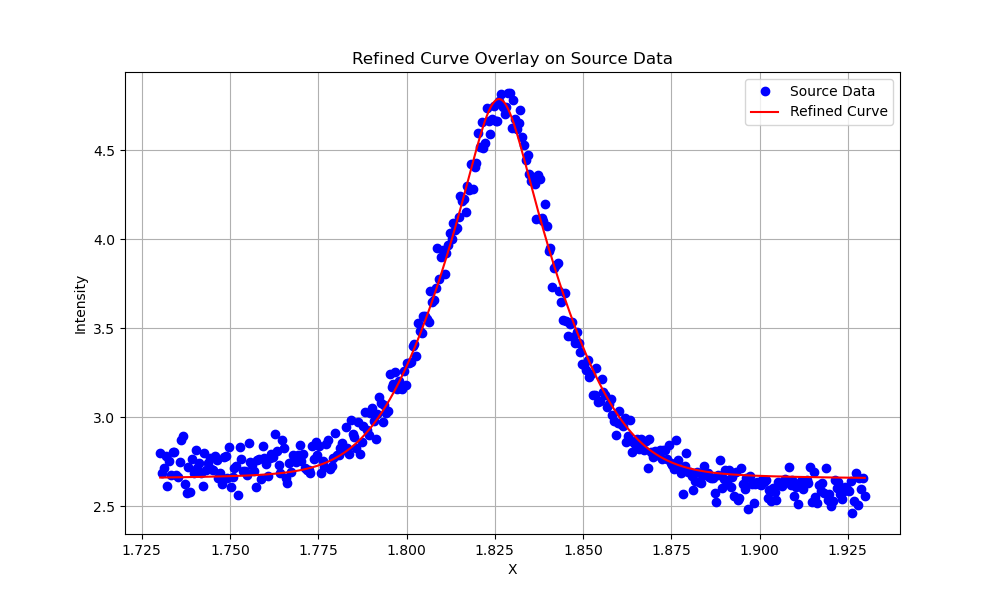

In [21]:
get_profile_peak_parameters(1.73, 1.93)